### taufit

 Simulate and fit a DRW light curve

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from multiprocessing import Pool
from itertools import repeat

Import package methods to simulate and fit DRW

In [31]:
import taufit
import importlib
importlib.reload(taufit)

<module 'taufit' from '/home/s1/cburke/taufit/taufit.py'>

In [32]:
from taufit import simulate_drw
from taufit import fit_drw

Generate simualted light curve with 6 seasons

In [63]:
#num_seasons = 6
#season_duration = 120 # days
#cadence = 7 # days
#x = [np.arange(365*i, 365*i + season_duration, cadence) for i in range(num_seasons)]
#x = np.array(x).flatten()
x = np.arange(0,2000,7)

Define function to simulate DRW light curves with similar amplitude fluctuations at a given timescale, typical mean magnitude, and error bars, with Gaussian white noise.

In [60]:
def simulate_and_fit_drw(x, log_tau_drw, sigma_hat=0.2, ymean=20, ysigma=0.02, seed=None, plot=False, verbose=False):
    tau = 10**log_tau_drw
    # Change SFinf to display similar amplitude fluctuations at a given timescale
    SFinf = sigma_hat*np.sqrt(tau/250)
    # Simulate and fit DRW
    y = simulate_drw(x, xmean=ymean, tau=tau, SFinf=SFinf)
    yerr = np.full(np.shape(y), ysigma)
    # Add RMS fluctuations
    y += np.random.normal(0,ysigma,len(y))
    # Note the inputs to fit_drw must have astropy units
    gp, samples = fit_drw(x*u.day, y*u.mag, yerr*u.mag, plot=plot, verbose=verbose)
    log_tau_drw_recovered = np.log10(1/np.exp(np.median(samples[:,1])))
    return log_tau_drw, log_tau_drw_recovered

Simulate $\tau_{\rm{DRW}}=250$ days:

Initial log-likelihood: 193.0458554262811
Final log-likelihood: 420.14497467782184
Running burn-in...
Running production...


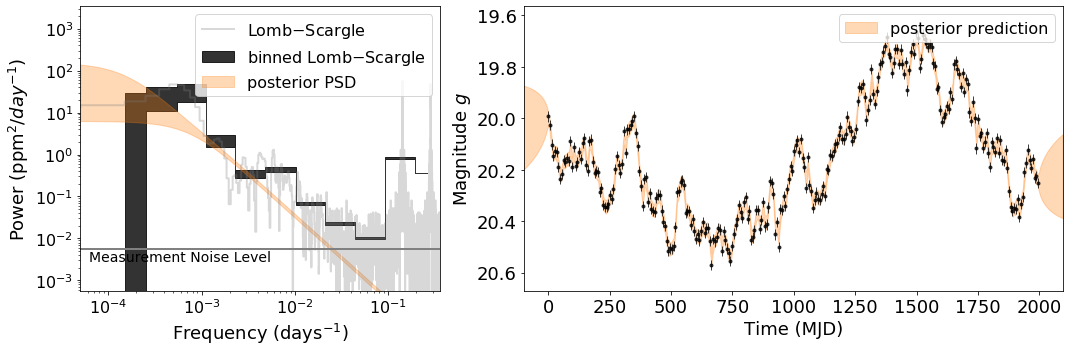

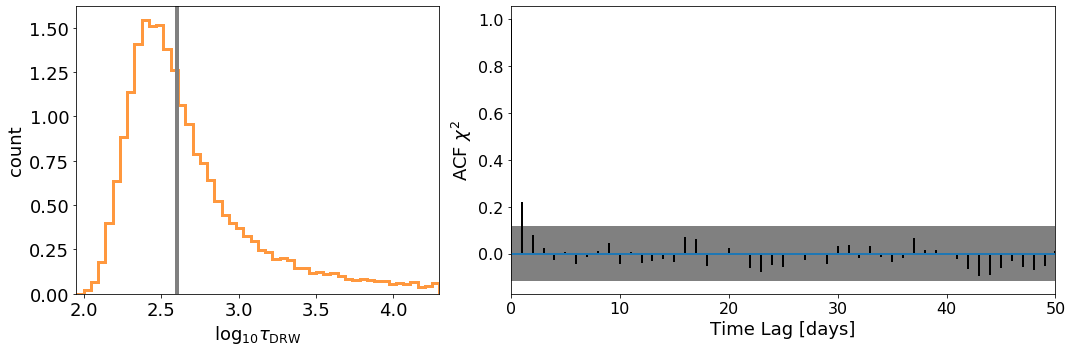

(2.3979400086720375, 2.559215930912952)

In [62]:
simulate_and_fit_drw(x, np.log10(250), plot=True, verbose=True)

### Assess bias in the fitting

Generate random DRW light curves with a range of input $\tau_{DRW}$, both seasonally-gapped and not, and see how well we can recover the input for each.

You may togggle whether to plot the output or not by changing the default arugments in `simulate_and_fit_drw` above.

In [69]:
# Modify the function above to create gaps in the light curve
def simulate_gapped(x, log_tau_drw, sigma_hat=0.2, ymean=20, ysigma=0.02, seed=None, plot=False, verbose=False):
    tau = 10**log_tau_drw
    # Change SFinf to display similar amplitude fluctuations at a given timescale
    SFinf = sigma_hat*np.sqrt(tau/250)
    # Simulate and fit DRW
    y = simulate_drw(x, xmean=ymean, tau=tau, SFinf=SFinf)
    yerr = np.full(np.shape(y), ysigma)
    # Add RMS fluctuations
    y += np.random.normal(0, ysigma, len(y))
    # Note the inputs to fit_drw must have astropy units
    gp, samples = fit_drw(x*u.day, y*u.mag, yerr*u.mag, plot=plot, verbose=verbose)
    log_tau_drw_recovered = np.log10(1/np.exp(np.median(samples[:,1])))
    # Gapped light curve
    x_gap = []; y_gap = []; yerr_gap = []
    days = 0
    for i in range(6):
        ind = (days<x) & (x<days+120)
        x_gap.append(x[ind])
        y_gap.append(y[ind])
        yerr_gap.append(yerr[ind])
        days += 365
    x_gap = np.concatenate(x_gap)
    y_gap = np.concatenate(y_gap)
    yerr_gap = np.concatenate(yerr_gap)
    # Note the inputs to fit_drw must have astropy units
    gp, samples = fit_drw(x_gap*u.day, y_gap*u.mag, yerr_gap*u.mag, plot=plot, verbose=verbose)
    log_tau_drw_recovered2 = np.log10(1/np.exp(np.median(samples[:,1])))
    # 
    return log_tau_drw, log_tau_drw_recovered, log_tau_drw_recovered2

In [70]:
# Generate input taus
x = np.arange(0,2000,7)
log_tau_drw_true = np.linspace(1, 5, 20*20)
# Use multiprocessing to pool each fitting to a simualted light curve
pool = Pool(20)
args = zip([x]*len(log_tau_drw_true), log_tau_drw_true)
taus = pool.starmap(simulate_gapped, args)
pool.close()
pool.join()
taus = np.array(taus)

/data/des90.a/data/cburke/conda/myenv/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/data/des90.a/data/cburke/conda/myenv/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/data/des90.a/data/cburke/conda/myenv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/des90.a/data/cburke/conda/myenv/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/data/des90.a/data/cburke/conda/myenv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/des90.a/data/cburke/conda/myenv/lib/python3

### Plot the results

Plot input $\tau_{\rm{DRW}}$ vs. output $\tau_{\rm{DRW}}$. Note the confirmation of the bias reported by [Kozlowski (2017)](https://ui.adsabs.harvard.edu/abs/2017A%26A...597A.128K/abstract) when the input $\tau_{\rm{DRW}}$ approaches 20% of the light curve baseline. 

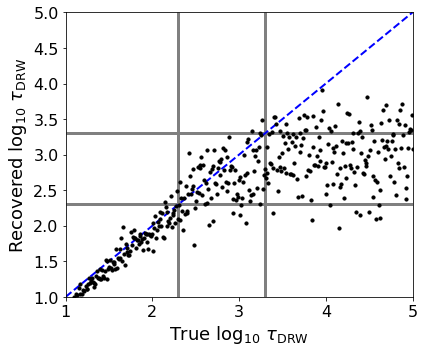

In [71]:
fig,ax = plt.subplots(1,1,figsize=(6,5), sharey=True)
ax.scatter(taus[:,0], taus[:,1], s=10, c='k')
ax.set_xlim(1,5)
ax.set_ylim(1,5)
ax.plot([1,5],[1,5], lw=2, color='b', zorder=-1, linestyle='dashed')
ax.tick_params('both',labelsize=16)
ax.set_xlabel(r'True $\log_{10}\ \tau_{\rm{DRW}}$',fontsize=18)
ax.set_ylabel(r'Recovered $\log_{10}\ \tau_{\rm{DRW}}$',fontsize=18)
#ax.legend(fontsize=16, loc=2)
# vertical lines at cadence (7 days) and baseline.
baseline = np.max(x) - np.min(x)
ax.vlines(np.log10(baseline),1,5, color='grey', lw=3, zorder=-1)
ax.hlines(np.log10(baseline),1,5, color='grey', lw=3, zorder=-1)
ax.vlines(np.log10(0.1*baseline),1,5, color='grey', lw=3, zorder=-1)
ax.hlines(np.log10(0.1*baseline),1,5, color='grey', lw=3, zorder=-1)

fig.tight_layout()

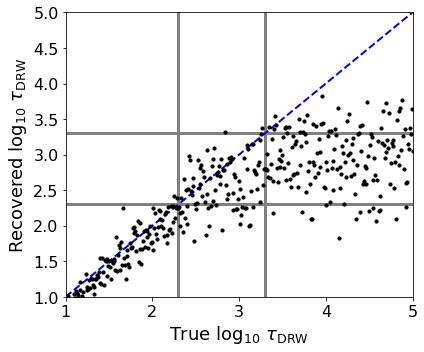

In [72]:
fig,ax = plt.subplots(1,1,figsize=(6,5), sharey=True)
ax.scatter(taus[:,0], taus[:,2], s=10, c='k')
ax.set_xlim(1,5)
ax.set_ylim(1,5)
ax.plot([1,5],[1,5], lw=2, color='b', zorder=-1, linestyle='dashed')
ax.tick_params('both',labelsize=16)
ax.set_xlabel(r'True $\log_{10}\ \tau_{\rm{DRW}}$',fontsize=18)
ax.set_ylabel(r'Recovered $\log_{10}\ \tau_{\rm{DRW}}$',fontsize=18)
#ax.legend(fontsize=16, loc=2)
# vertical lines at cadence (7 days) and baseline.
baseline = np.max(x) - np.min(x)
ax.vlines(np.log10(baseline),1,5, color='grey', lw=3, zorder=-1)
ax.hlines(np.log10(baseline),1,5, color='grey', lw=3, zorder=-1)
ax.vlines(np.log10(0.1*baseline),1,5, color='grey', lw=3, zorder=-1)
ax.hlines(np.log10(0.1*baseline),1,5, color='grey', lw=3, zorder=-1)

fig.tight_layout()